<a href="https://colab.research.google.com/github/Sajad-Adil/Time-Series-Classification-using-Machine-Learning-on-EEG-Data/blob/main/EEG_Signal_Classification_(5_classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsfresh

####Import libraries

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, feature_selection, model_selection, pipeline, preprocessing, metrics, datasets, neighbors, tree, ensemble, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import pipeline
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#### Unzip dataset

In [ ]:
# this code will just extract data from BonnDataset zip file

# Path to the zip file
zip_path = '/content/BonnDataset.zip'
extract_dir = '/content/Bonn_data'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

##Automated (Loading, pre-processing, and feature extraction)



### Load the Dataset



In [ ]:

def read_txt_files_to_df(folder_path):

    records = []


    for filename in os.listdir(folder_path):
        if filename.endswith('.txt') or filename.endswith('.TXT'):
            file_path = os.path.join(folder_path, filename)

            with open(file_path, 'r') as file:
                content = file.readlines()

                samples = [float(line.strip()) for line in content]
                if len(samples) == 4097:
                    records.append(samples)
                else:
                    print(f"File {filename} does not contain exactly 4097 samples. Skipping this file.")

    # Create a DataFrame from the list of records
    df = pd.DataFrame(records)

    return df

# Example usage




In [ ]:


df0 = read_txt_files_to_df('/content/Bonn_data/Z')
df0['class'] = 0
df1 = read_txt_files_to_df('/content/Bonn_data/O')

df1['class'] = 1
df2 = read_txt_files_to_df('/content/Bonn_data/N')
df2['class'] = 2
df3 = read_txt_files_to_df('/content/Bonn_data/F')
df3['class'] = 3
df4 = read_txt_files_to_df('/content/Bonn_data/S')
df4['class'] = 4


In [ ]:
combined_data = pd.concat([df0, df1, df2, df3, df4], axis=0)

In [ ]:
combined_data.reset_index(drop=True, inplace=True)


In [ ]:
combined_data

,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,class
0,36.0,27.0,24.0,12.0,6.0,-11.0,-22.0,-21.0,-10.0,-3.0,...,32.0,65.0,97.0,100.0,88.0,80.0,66.0,59.0,6.0,0
1,-55.0,-32.0,1.0,36.0,74.0,108.0,110.0,93.0,60.0,45.0,...,3.0,-17.0,-35.0,-59.0,-76.0,-85.0,-73.0,-65.0,-39.0,0
2,-44.0,-35.0,-18.0,2.0,-5.0,2.0,-7.0,-20.0,-1.0,-1.0,...,-3.0,-32.0,-2.0,31.0,43.0,65.0,44.0,55.0,66.0,0
3,-20.0,-3.0,2.0,16.0,29.0,36.0,34.0,29.0,38.0,26.0,...,-42.0,-32.0,-34.0,-25.0,-27.0,-34.0,-28.0,-10.0,3.0,0
4,-19.0,-1.0,33.0,51.0,49.0,26.0,-15.0,-42.0,-45.0,-37.0,...,-14.0,-25.0,-19.0,-28.0,-49.0,-71.0,-70.0,-25.0,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,23.0,144.0,228.0,260.0,255.0,218.0,178.0,126.0,60.0,6.0,...,-127.0,-123.0,-152.0,-231.0,-272.0,-272.0,-155.0,6.0,-221.0,4
496,80.0,86.0,91.0,100.0,107.0,116.0,127.0,153.0,207.0,258.0,...,34.0,46.0,48.0,48.0,43.0,42.0,54.0,78.0,89.0,4
497,98.0,88.0,76.0,59.0,40.0,17.0,6.0,-3.0,-5.0,-15.0,...,-301.0,-322.0,-200.0,-29.0,151.0,250.0,244.0,184.0,70.0,4
498,-445.0,-645.0,-652.0,-562.0,-496.0,-442.0,-375.0,-293.0,-218.0,-146.0,...,355.0,347.0,335.0,326.0,313.0,294.0,264.0,219.0,-346.0,4


In [ ]:
combined_data.shape

(500, 4098)

In [ ]:
y = combined_data['class']
y.unique()


array([0, 1, 2, 3, 4])

In [ ]:
y.shape

(500,)

In [ ]:
# copy the combined data
data = combined_data.copy()

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,class
0,36.0,27.0,24.0,12.0,6.0,-11.0,-22.0,-21.0,-10.0,-3.0,...,32.0,65.0,97.0,100.0,88.0,80.0,66.0,59.0,6.0,0
1,-55.0,-32.0,1.0,36.0,74.0,108.0,110.0,93.0,60.0,45.0,...,3.0,-17.0,-35.0,-59.0,-76.0,-85.0,-73.0,-65.0,-39.0,0
2,-44.0,-35.0,-18.0,2.0,-5.0,2.0,-7.0,-20.0,-1.0,-1.0,...,-3.0,-32.0,-2.0,31.0,43.0,65.0,44.0,55.0,66.0,0
3,-20.0,-3.0,2.0,16.0,29.0,36.0,34.0,29.0,38.0,26.0,...,-42.0,-32.0,-34.0,-25.0,-27.0,-34.0,-28.0,-10.0,3.0,0
4,-19.0,-1.0,33.0,51.0,49.0,26.0,-15.0,-42.0,-45.0,-37.0,...,-14.0,-25.0,-19.0,-28.0,-49.0,-71.0,-70.0,-25.0,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,23.0,144.0,228.0,260.0,255.0,218.0,178.0,126.0,60.0,6.0,...,-127.0,-123.0,-152.0,-231.0,-272.0,-272.0,-155.0,6.0,-221.0,4
496,80.0,86.0,91.0,100.0,107.0,116.0,127.0,153.0,207.0,258.0,...,34.0,46.0,48.0,48.0,43.0,42.0,54.0,78.0,89.0,4
497,98.0,88.0,76.0,59.0,40.0,17.0,6.0,-3.0,-5.0,-15.0,...,-301.0,-322.0,-200.0,-29.0,151.0,250.0,244.0,184.0,70.0,4
498,-445.0,-645.0,-652.0,-562.0,-496.0,-442.0,-375.0,-293.0,-218.0,-146.0,...,355.0,347.0,335.0,326.0,313.0,294.0,264.0,219.0,-346.0,4


### Convert into appropriate format

In [ ]:
data["id"] = data.index
data = data.drop(['class'], axis=1)
data = data.melt(id_vars='id', var_name="time").sort_values(['id', 'time']).reset_index(drop=True)

In [ ]:
data

,id,time,value
0,0,0,36.0
1,0,1,27.0
2,0,2,24.0
3,0,3,12.0
4,0,4,6.0
...,...,...,...
2048495,499,4092,-10.0
2048496,499,4093,-5.0
2048497,499,4094,-7.0
2048498,499,4095,-7.0


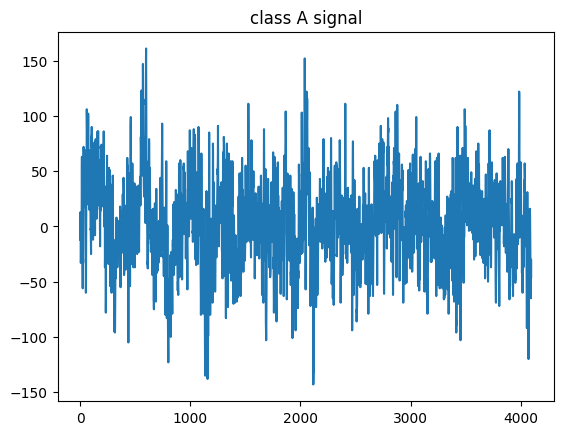

In [ ]:
from matplotlib import pyplot as plt

plt.title('class A signal')
plt.plot(data[data['id'] == 10].set_index('time').value)
plt.show()

###Feature extraction


In [ ]:
EEG_features = extract_features(data, column_id="id", column_sort="time", default_fc_parameters=EfficientFCParameters())

Feature Extraction: 100%|██████████| 500/500 [05:31<00:00,  1.51it/s]


In [ ]:
impute(EEG_features)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,24782.0,6619714.0,11.066895,-0.007324,-0.005372,6.0,...,0.622877,0.759436,1.763009,1.458082,2.306672,3.268767,4.301151,5.308408,0.0,134.714286
1,1.0,0.0,0.0,1.0,33392.0,11407306.0,12.745605,0.003906,0.000366,8.0,...,0.262742,0.522487,1.399967,1.456703,2.291283,3.235342,4.254610,5.249602,0.0,227.428571
2,1.0,0.0,0.0,1.0,4191.0,6526241.0,14.558594,0.026855,0.000244,1.0,...,0.492803,0.731788,1.877033,1.629859,2.700467,3.888196,5.148322,6.299744,0.0,139.285714
3,1.0,0.0,0.0,1.0,-8482.0,2901078.0,8.607666,0.005615,-0.000488,-2.0,...,0.334825,0.679618,1.775853,1.558947,2.531856,3.630077,4.792835,5.914107,0.0,88.428571
4,1.0,0.0,0.0,1.0,-19140.0,7973302.0,15.139404,0.004150,0.000611,-5.0,...,0.571267,0.954399,1.865344,1.447064,2.278335,3.224710,4.221737,5.232660,0.0,153.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.0,0.0,0.0,1.0,13447.0,275419177.0,59.614746,-0.059570,-0.042491,-21.0,...,0.204871,0.352599,1.199237,1.236926,1.853029,2.532509,3.261509,3.986503,0.0,929.428571
496,1.0,0.0,0.0,1.0,-66395.0,141273895.0,38.728760,0.002197,0.000611,21.0,...,0.170467,0.307703,1.090237,1.125873,1.616420,2.162293,2.752742,3.337478,0.0,504.142857
497,1.0,0.0,0.0,1.0,-14032.0,69572550.0,24.953613,-0.006836,-0.012698,13.0,...,0.433167,0.666300,1.532356,1.342533,2.056078,2.862034,3.722112,4.551717,0.0,644.000000
498,1.0,0.0,0.0,1.0,-9843.0,540440799.0,69.300537,0.024170,-0.044567,51.0,...,0.243347,0.477200,1.397266,1.170619,1.673692,2.228993,2.849395,3.463492,0.0,1380.285714


In [ ]:


EEG_features.isnull().sum().sum()


0

### Feature selection using tsfresh

In [ ]:
selected_features = select_features(EEG_features, y)

In [ ]:
selected_features.shape

(500, 382)

In [ ]:
y.shape

(500,)

Data Normalization

In [ ]:
scalar= preprocessing.StandardScaler()
xnorm = scalar.fit_transform(selected_features)

##Modeling

### Data split using K fold cross validation

In [ ]:
stratified_shuffled_k_fold = model_selection.StratifiedShuffleSplit(
    n_splits=5, random_state = 42
)

In [ ]:
def kfold_train_test_split(x,y,train_indices,test_indices):
    return x[train_indices], x[test_indices], y[train_indices], y[test_indices]


A function for model evaluation

In [ ]:
def evaluate_model(x, y, model):
  scores = []

  for train_indices, test_indices in stratified_shuffled_k_fold.split(x, y):
    x_train, x_test, y_train, y_test = kfold_train_test_split(x, y, train_indices, test_indices)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
          # Calculate scores
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred,average='weighted')
    precision = metrics.precision_score(y_test, y_pred,average='weighted')
    recall = metrics.recall_score(y_test, y_pred,average='weighted')
      # Create scores dictionary
    scores_dict = {"accuracy": accuracy,"f1": f1, "precision": precision, "recall": recall}
    cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
      # Append to scores array
    scores.append(scores_dict)
  scores_df = pd.DataFrame(scores)


  return scores_df.mean(), scores_df


###Logistic Regression

In [ ]:
logistic_regression=pipeline.Pipeline([
               ('logistic',linear_model.LogisticRegression())])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


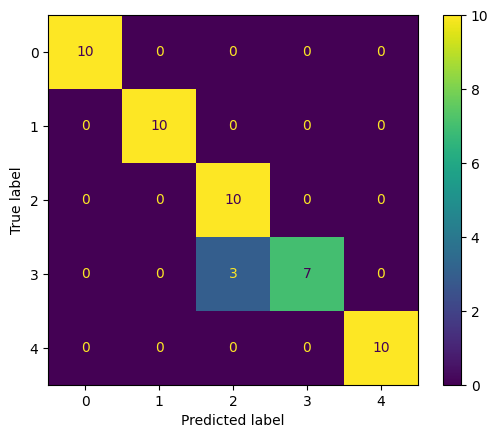

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


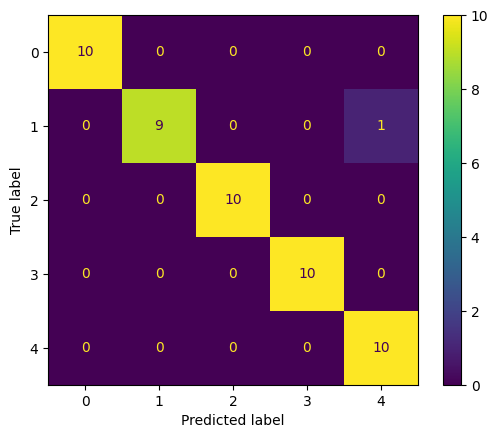

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


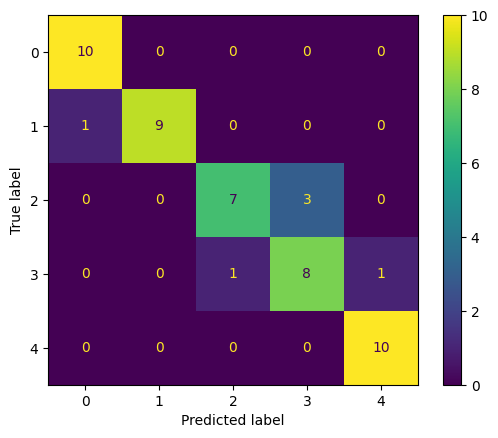

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


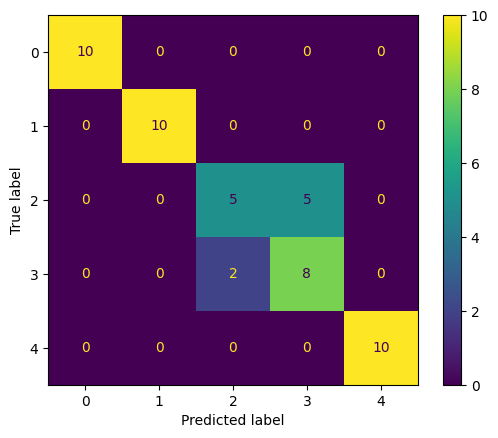

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


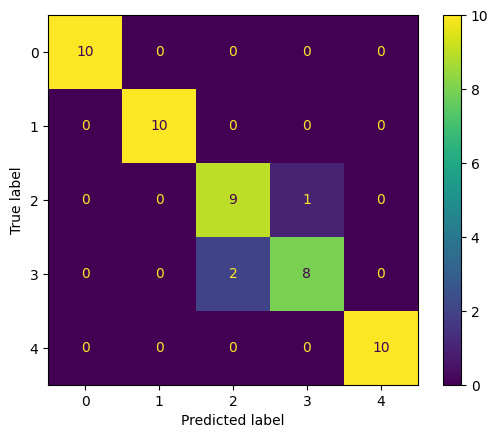

(accuracy     0.920000
 f1           0.918712
 precision    0.925421
 recall       0.920000
 dtype: float64,
    accuracy        f1  precision  recall
 0      0.94  0.938619   0.953846    0.94
 1      0.98  0.979950   0.981818    0.98
 2      0.88  0.878363   0.884091    0.88
 3      0.86  0.856777   0.865934    0.86
 4      0.94  0.939850   0.941414    0.94)

In [ ]:
evaluate_model(xnorm, y, logistic_regression)

###KNN

In [ ]:
from sklearn import neighbors

In [ ]:
knn=pipeline.Pipeline([
               ('model' ,neighbors.KNeighborsClassifier(n_neighbors=5))])

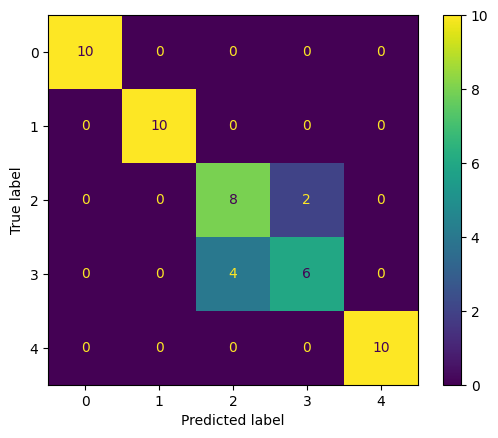

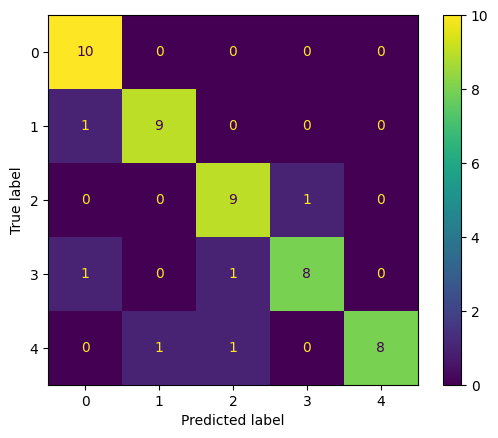

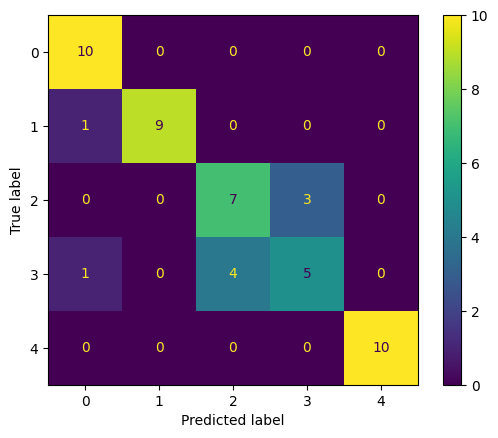

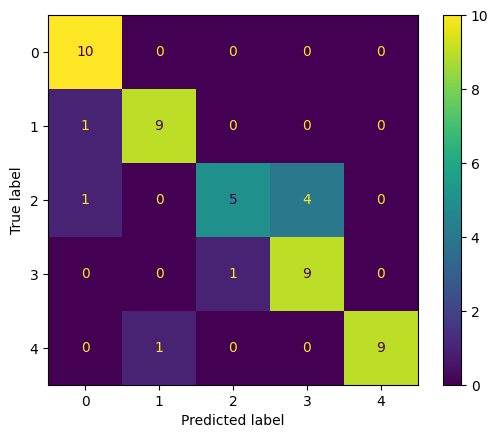

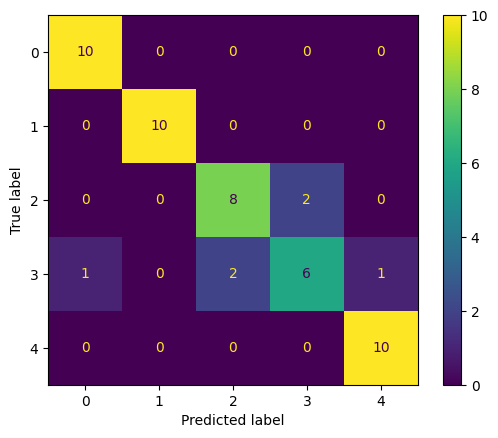

(accuracy     0.860000
 f1           0.856214
 precision    0.863157
 recall       0.860000
 dtype: float64,
    accuracy        f1  precision  recall
 0      0.88  0.878788   0.883333    0.88
 1      0.88  0.879446   0.888081    0.88
 2      0.82  0.815736   0.818939    0.82
 3      0.84  0.832814   0.851795    0.84
 4      0.88  0.874286   0.873636    0.88)

In [ ]:
evaluate_model(xnorm, y, knn)

###Decision Tree

In [ ]:
decision_tree = tree.DecisionTreeClassifier(criterion='entropy')

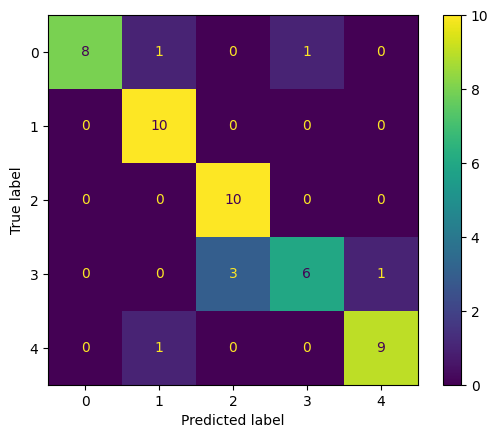

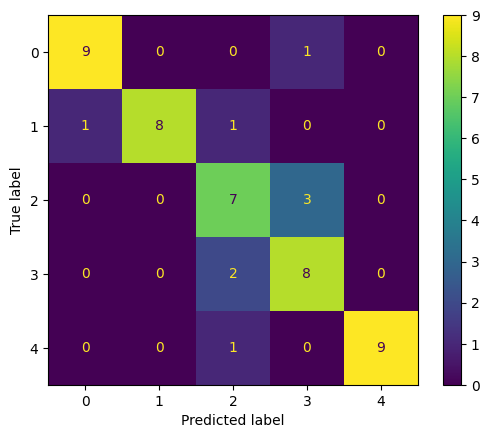

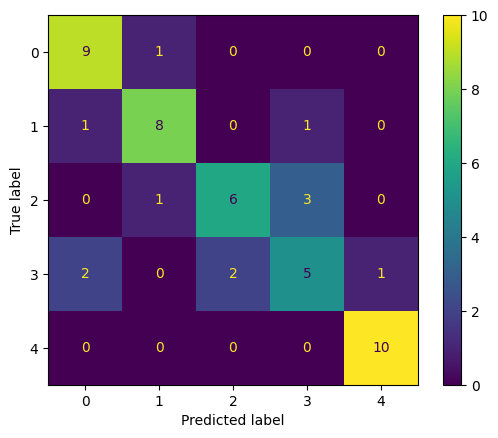

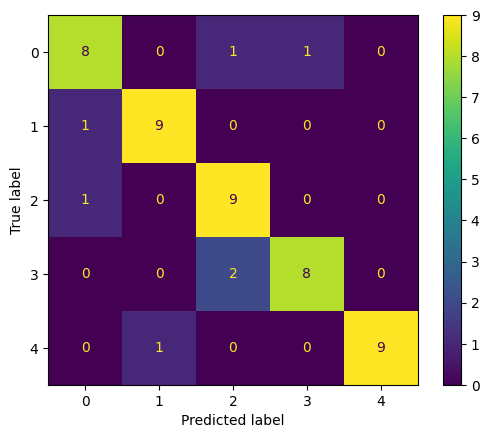

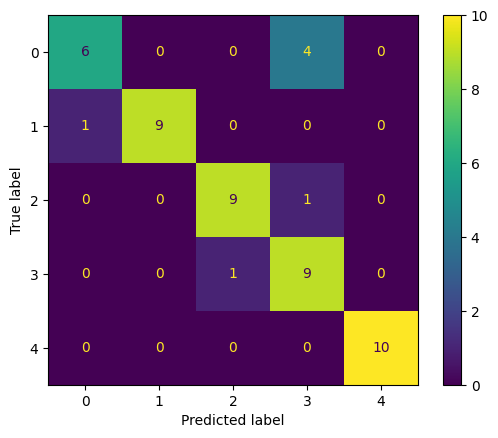

(accuracy     0.832000
 f1           0.831123
 precision    0.842651
 recall       0.832000
 dtype: float64,
    accuracy        f1  precision  recall
 0      0.86  0.854685   0.871941    0.86
 1      0.82  0.826039   0.840606    0.82
 2      0.76  0.752709   0.752929    0.76
 3      0.86  0.861531   0.867778    0.86
 4      0.86  0.860650   0.880000    0.86)

In [ ]:
evaluate_model(xnorm, y, decision_tree)

###Random Forest

In [ ]:
rf=ensemble.RandomForestClassifier(n_estimators=250,criterion='entropy')

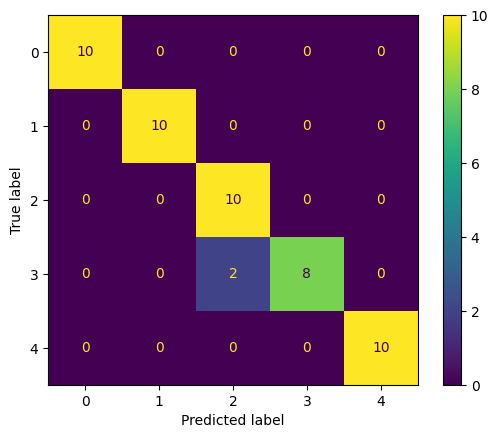

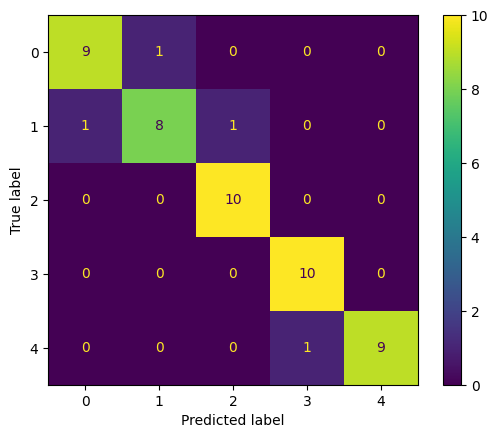

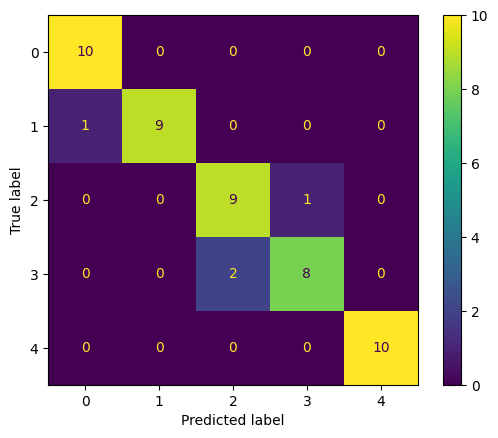

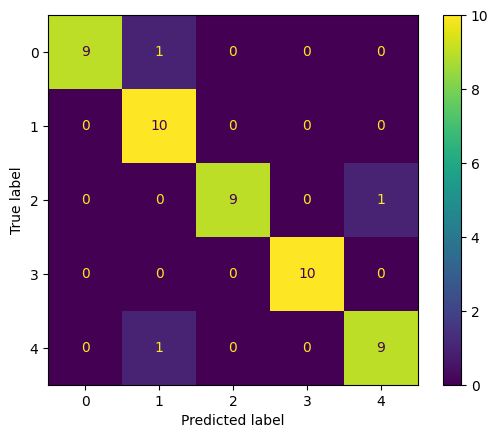

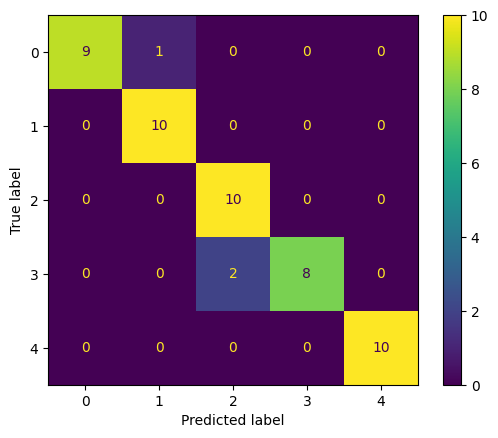

(accuracy     0.936000
 f1           0.935711
 precision    0.941293
 recall       0.936000
 dtype: float64,
    accuracy        f1  precision  recall
 0      0.96  0.959596   0.966667    0.96
 1      0.92  0.918847   0.921414    0.92
 2      0.92  0.919799   0.923232    0.92
 3      0.94  0.940766   0.946667    0.94
 4      0.94  0.939546   0.948485    0.94)

In [ ]:
evaluate_model(xnorm, y, rf)

###SVM

In [ ]:
svc =pipeline.Pipeline([
               ('model' ,svm.SVC( kernel= 'linear'))])


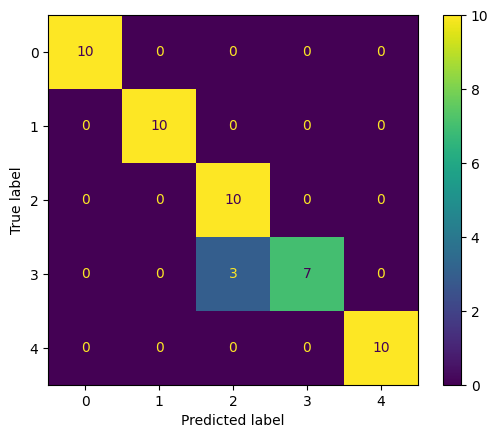

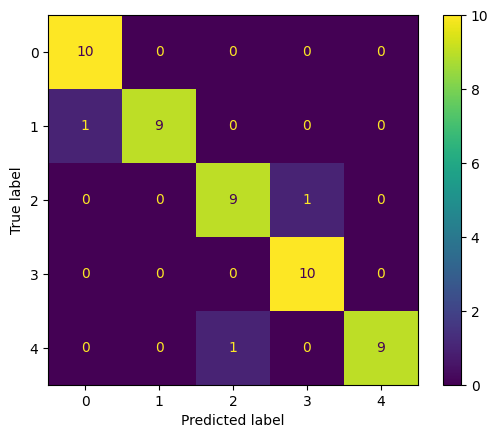

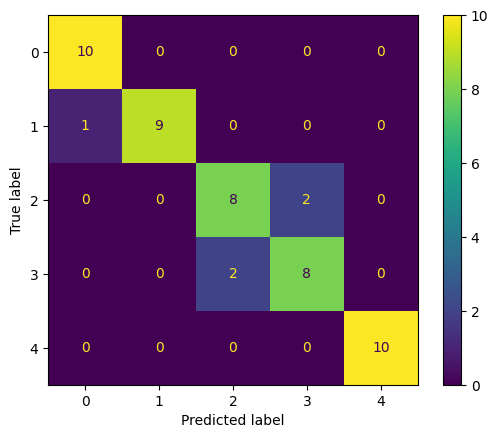

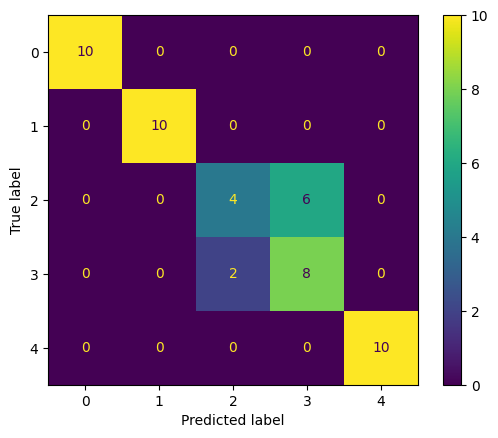

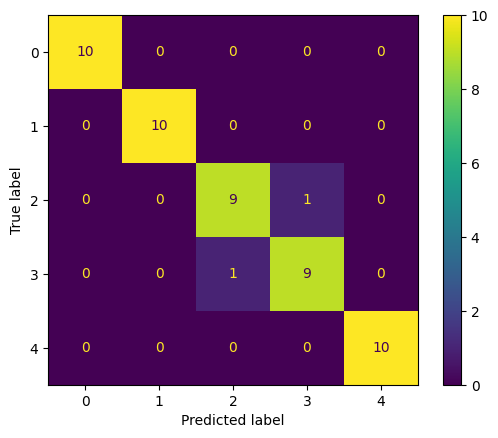

(accuracy     0.916000
 f1           0.914360
 precision    0.921384
 recall       0.916000
 dtype: float64,
    accuracy        f1  precision  recall
 0      0.94  0.938619   0.953846    0.94
 1      0.94  0.939900   0.943636    0.94
 2      0.90  0.899950   0.901818    0.90
 3      0.84  0.833333   0.847619    0.84
 4      0.96  0.960000   0.960000    0.96)

In [ ]:
evaluate_model(xnorm, y, svc)

## Hyperparameter tuning of the best model (Random Forest)

Range of parameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:

rf_model = RandomForestClassifier()

In [ ]:
kfold = model_selection.StratifiedShuffleSplit(2, random_state=42)

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = kfold, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(xnorm, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
205 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
205 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=None,
            train_size=None),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

Selecting Optimal model paramters using Grid Search CV

In [ ]:

params = {
    'bootstrap': [False],
    'max_depth': [90, 100, 110],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [5, 10, 12],
    'n_estimators': [300, 1000, 1500]
}

In [ ]:
scoring = {
    "accuracy": metrics.make_scorer(metrics.accuracy_score),

}

In [ ]:
gs = model_selection.GridSearchCV(
    rf_model, params, cv=kfold, scoring=scoring, refit="accuracy", verbose=2
)

In [ ]:

gs.fit(xnorm, y)


Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV] END bootstrap=False, criterion=gini, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.4s
[CV] END bootstrap=False, criterion=gini, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.6s
[CV] END bootstrap=False, criterion=gini, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.5s
[CV] END bootstrap=False, criterion=gini, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.6s
[CV] END bootstrap=False, criterion=gini, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1500; total time=  12.4s
[CV] END bootstrap=False, criterion=gini, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1500; total time=  12.5s
[CV] END bootst

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=2, random_state=42, test_size=None,
            train_size=None),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'criterion': ['gini', 'entropy'],
                         'max_depth': [90, 100, 110], 'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10, 12],
                         'n_estimators': [300, 1000, 1500]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score)}, verbose=2)

In [ ]:

print("Best Hyperparameters:", gs.best_params_)
print("Best Score (accuracy): ", gs.best_score_)

Best Hyperparameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1500}
Best Score (Recall):  0.95


### Creating the best model, with the best hyperparameters

In [ ]:
rf_model= pipeline.Pipeline([
                                      ('model', RandomForestClassifier(
                                          bootstrap=False, criterion='entropy', max_depth=90, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=1500
                                      ))])


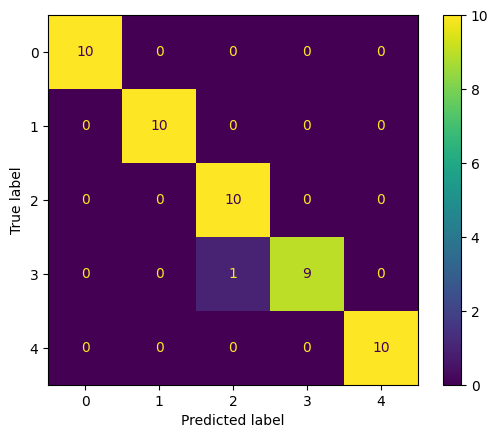

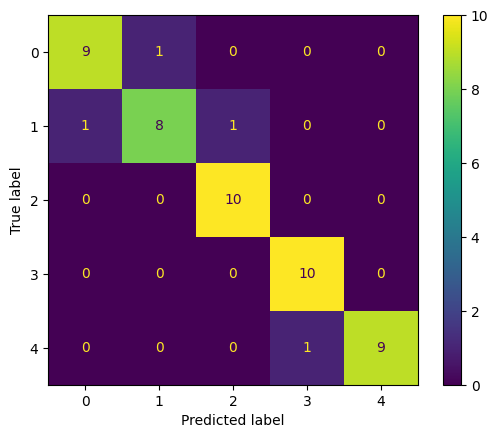

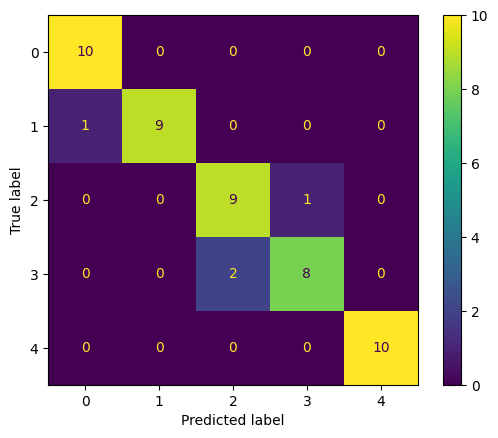

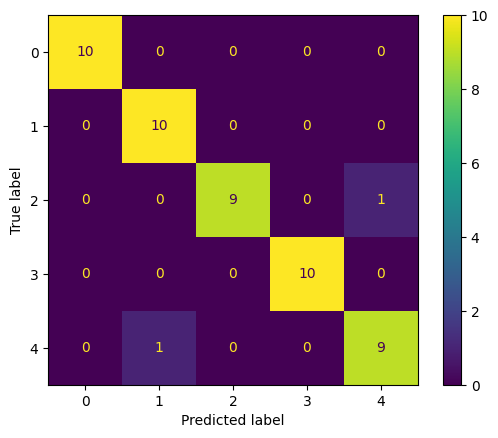

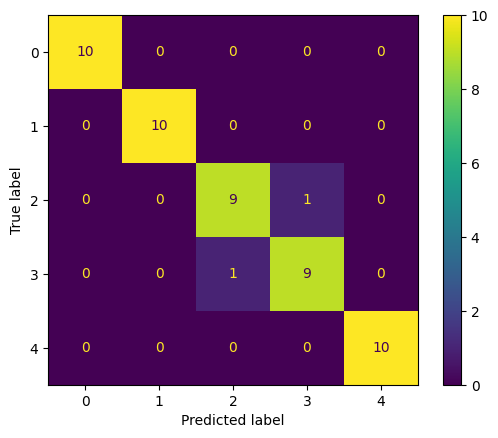

(accuracy     0.948000
 f1           0.947709
 precision    0.949657
 recall       0.948000
 dtype: float64,
    accuracy        f1  precision  recall
 0      0.98  0.979950   0.981818    0.98
 1      0.92  0.918847   0.921414    0.92
 2      0.92  0.919799   0.923232    0.92
 3      0.96  0.959950   0.961818    0.96
 4      0.96  0.960000   0.960000    0.96)

In [ ]:
evaluate_model(xnorm, y, rf_model)